In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
import ecg_cnn_architecture as eca
import ecg_cnn_training as ect
import data_handling as edh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
!du -h --max-depth=1 ../input/

4.5G	../input/12-lead-ecg-dataset-10kpatients-zheng-2019
4.5G	../input/


In [ ]:
# Remove bad data
ecg_data_files = np.sort(glob.glob('../input/12-lead-ecg-dataset-10kpatients-zheng-2019/ECGDataDenoised/ECGDataDenoised/*.csv'))
bad_files = []
for f in ecg_data_files:
    try:
        ecg_data_test = np.loadtxt(f, dtype=float, delimiter=',')
        if ecg_data_test.shape != (5000, 12):
            bad_files.append(f)
            # print(ecg_data_test.shape, f)
            continue
        if np.isnan(ecg_data_test).sum()>0:
            # print('nan detected',np.isnan(ecg_data_test).sum())
            bad_files.append(f)
            continue
        if (ecg_data_test!=0).sum()==0:
            # print('all zeros')
            bad_files.append(f)
    except(ValueError):
        bad_files.append(f)
        print(ecg_data_test.shape, f, 'val_error')  
bad_files = [f.split('/')[-1].split('.csv')[0] for f in bad_files]

In [35]:
diagnostics_table = pd.read_excel("../input/12-lead-ecg-dataset-10kpatients-zheng-2019/Diagnostics.xlsx")
FileNames = diagnostics_table['FileName']
mask = ~FileNames.isin(bad_files)
diagnostics_table = diagnostics_table[mask]
FileNames = diagnostics_table['FileName']
# Target variables
y_rhythm = diagnostics_table["Rhythm"]
# y_beat = diagnostics_table["Beat"]


# Encode targets
rhythm_encoder = LabelEncoder()
rhythm_encoder.fit(y_rhythm)
class_names = rhythm_encoder.classes_
y_rhythm = rhythm_encoder.transform(y_rhythm)

In [36]:
data_files_ordered = ['../input/12-lead-ecg-dataset-10kpatients-zheng-2019/ECGDataDenoised/ECGDataDenoised/' + name + '.csv' for name in FileNames]
train_loader, val_loader = edh.create_simple_dataloaders(data_files_ordered, y_rhythm) 
# train_loader, val_loader = edh.create_ecg_dataloaders(data_files_ordered, y_rhythm) 


In [37]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
num_classes =np.unique(y_rhythm).shape[0]
model = eca.resnet18_1d(num_classes=num_classes, input_channels=12)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cuda
Total parameters: 8,742,155


In [38]:
# Initialize trainer
trainer = ect.ECGTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=num_classes,
    class_weights=None, lr=1e-4
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting ECG ResNet Training...
Device: cuda
Model parameters: 8,742,155

Epoch 1/4
--------------------------------------------------
Train Batch 0: Loss: 2.5063, Acc: 0.00%
Train Batch 50: Loss: 0.7393, Acc: 60.66%
Train Batch 100: Loss: 0.9716, Acc: 67.51%
Train Batch 150: Loss: 0.7151, Acc: 70.90%
Train Batch 200: Loss: 0.9362, Acc: 72.79%
Train Batch 250: Loss: 0.4807, Acc: 75.00%
Train Batch 300: Loss: 0.5723, Acc: 76.54%
Train Batch 350: Loss: 0.7837, Acc: 77.49%
Train Batch 400: Loss: 0.8182, Acc: 78.52%
Train Batch 450: Loss: 0.9348, Acc: 79.13%
Train Batch 500: Loss: 0.3005, Acc: 79.65%
Train Loss: 0.6418, Train Acc: 80.08%
Val Loss: 0.4593, Val Acc: 85.65%, Val F1: 0.8182
Learning Rate: 0.000100
✓ New best model saved! Val Loss: 0.4593

Epoch 2/4
--------------------------------------------------
Train Batch 0: Loss: 0.4652, Acc: 93.75%
Train Batch 50: Loss: 0.5443, Acc: 84.68%
Train Batch 100: Loss: 0.2588, Acc: 86.01%
Train Batch 150: Loss: 0.3325, Acc: 86.42%
Train Batch 

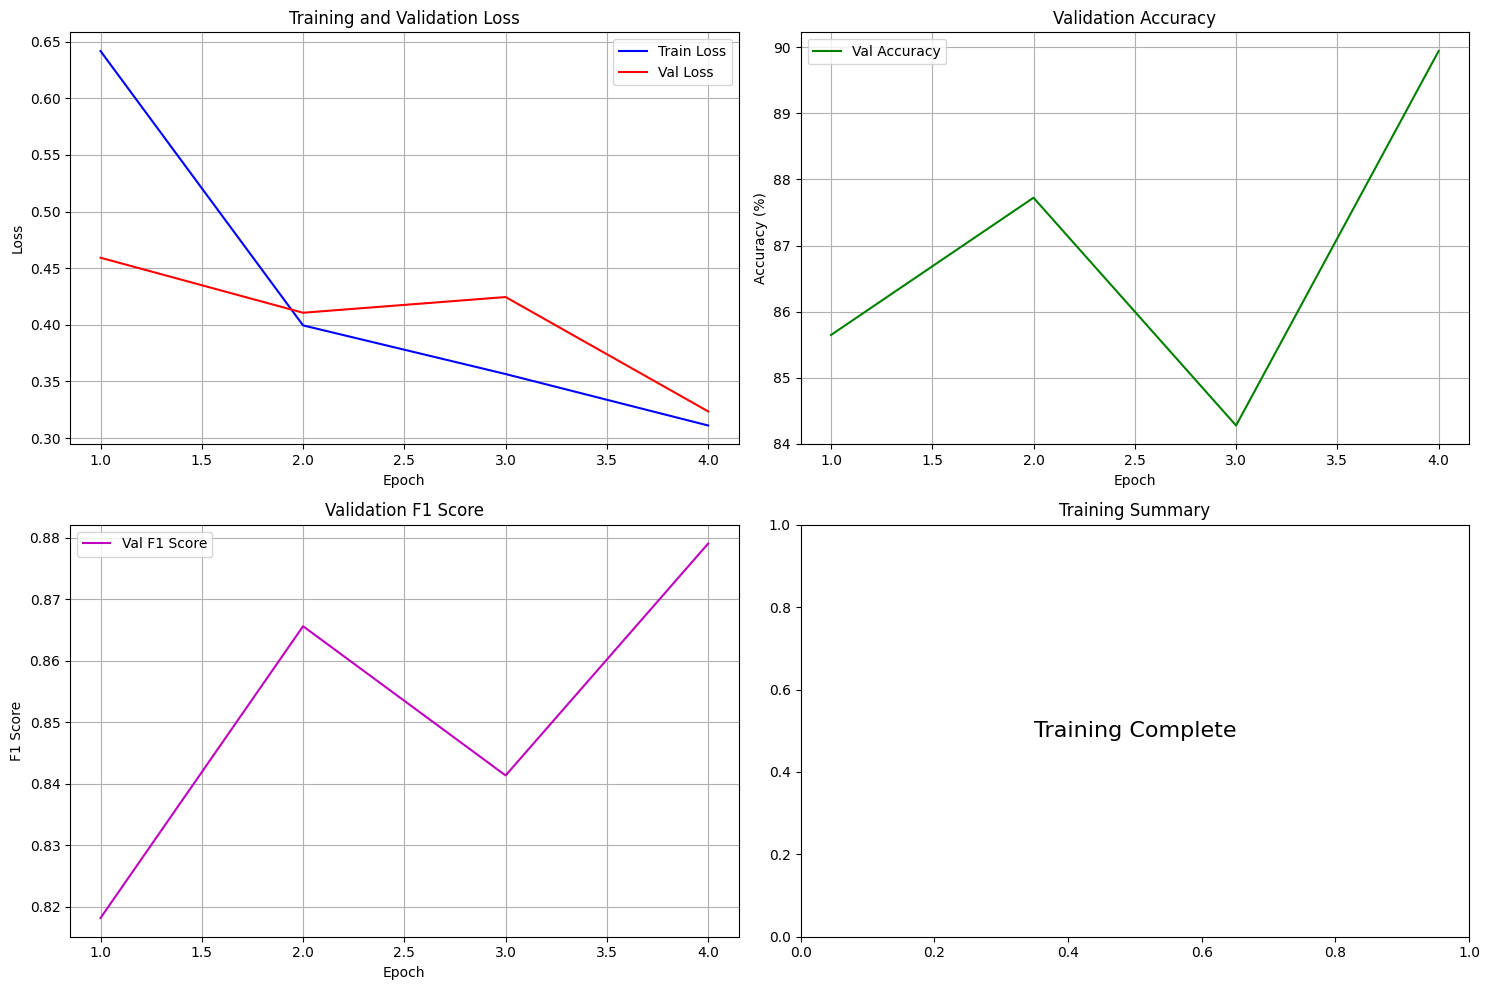


Training complete! Best model saved as 'best_ecg_resnet.pth'
Best validation loss: 0.3235
Final validation accuracy: 89.94%


In [39]:
trained_model = trainer.train(
    epochs=4,
    early_stopping_patience=2,
    save_path='best_ecg_resnet.pth'
)

# Plot training history
trainer.plot_training_history()

print("\nTraining complete! Best model saved as 'best_ecg_resnet.pth'")
print(f"Best validation loss: {trainer.best_val_loss:.4f}")
print(f"Final validation accuracy: {trainer.val_accuracies[-1]:.2f}%")

In [45]:
np.unique(all_preds)

array([ 0,  1,  5,  7,  8,  9, 10])

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10])

In [46]:
len(class_names)

11

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

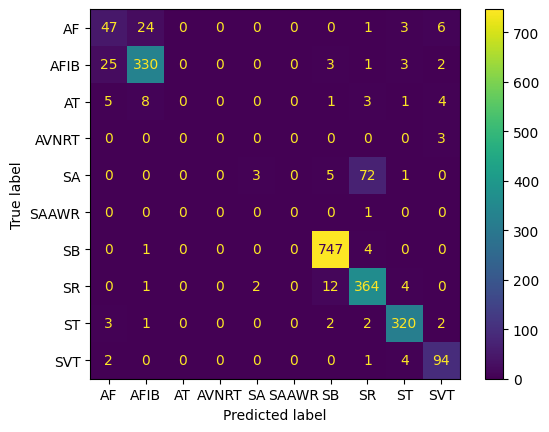

In [53]:
cmatrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cmatrix, display_labels=class_names[np.unique(all_labels)])
disp.plot()
plt.show()

In [ ]:
|